## LSTM models
We developed 4 models with two extra modifications.

## Model Summaries
TThis project explores a sequence of LSTM architectures to predict next-day stock direction using engineered price-based features. The progression begins with simple sequence modeling and gradually incorporates deeper nonlinear layers, longer temporal context, and finally multi-stock learning through symbol embeddings.

The modeling narrative evolves as follows:

Model 1 establishes a minimal baseline LSTM for binary movement prediction.

Models 2 explore deeper dense layers, dropout, and extended training to assess whether nonlinear transformations or longer convergence improve performance.

Models 3-A and 3-B transition to multi-stock learning, adding a symbol-embedding pathway that allows the LSTM to learn stock-specific patterns jointly across all tickers.

Finally, the project investigates how architectural complexity, embedding size, and dense depth affect generalization.

Across all models, results consistently show that historical OHLCV data alone provides insufficient predictive signal for next-day price direction. Performance remains close to random, suggesting that future modeling efforts should incorporate richer feature sets (technical indicators, sentiment, macro factors) and longer windows.


Here is the summary of the models architecture, key aspect and their performance

| **Model**                                | **Architecture / Setup**                                                                                           | **Key Idea**                                                                                  |
|------------------------------------------|---------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **Model 1 – Baseline LSTM**             | LSTM(64) → Dropout(0.2) → Dense(1, sigmoid); 20-day window                                                         | Minimal LSTM baseline to test whether past OHLCV data can support next-day direction labels. |
| **Model 2 – Deeper LSTM**             | LSTM(64) → Dense(64, softplus) → Dropout(0.1) → Dense(12, softplus) → Dense(1, sigmoid); 20-day window             | Adds nonlinear dense layers and a tuned Adam optimizer to enrich feature representation.      |
| **Model 3-A – Multi-Stock LSTM + Emb**  | Embedding(8) → Flatten → RepeatVector → Concatenate with sequence → LSTM(64) → Dropout(0.2) → Dense(32, softplus) → Dense(1, sigmoid); 60-day window | Introduces ticker embeddings so the LSTM can learn shared patterns across multiple symbols.   |
| **Model 3-B – Deeper Multi-Stock LSTM** | Embedding(12) → Flatten → RepeatVector → Concatenate with sequence → LSTM(64) → Dense(64, softplus) → Dropout(0.2) → Dense(32, softplus) → Dropout(0.2) → Dense(1, sigmoid); 60-day window | Uses a larger embedding and deeper dense head to increase capacity for cross-stock structure. |



In [1]:
import os
print(os.getcwd())
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)

c:\Users\cheki\dsi\project\Stock-Trend-Analysis-with-NYSE\models


## Data preparation, introducing the features, and loading engineered dataframe

In [2]:
# Defining features list
base_features = [    'open',    'high',    'low',    'close',    'volume',    'log_return_1d']
extra_features = [
'close_lag1', 'log_return_lag1', 'log_return_lag2', 'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5', 'rolling_std_10',
 'momentum_5', 'momentum_10', 'volume_change_1d', 'volume_zscore_10', 'high_low_ratio', 'close_open_ratio']

features = base_features + extra_features
target_cls = 'price_up_tomorrow'
print("Num features:", len(features))
print("Features:", features)


Num features: 20
Features: ['open', 'high', 'low', 'close', 'volume', 'log_return_1d', 'close_lag1', 'log_return_lag1', 'log_return_lag2', 'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5', 'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d', 'volume_zscore_10', 'high_low_ratio', 'close_open_ratio']


In [3]:
use_cols = ['symbol', 'date', target_cls] + features
# Loading the optimized data file 

df_fe = pd.read_parquet("../data/processed/price_features.parquet",
                        columns=use_cols)
list(df_fe.columns)


['symbol',
 'date',
 'price_up_tomorrow',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'log_return_1d',
 'close_lag1',
 'log_return_lag1',
 'log_return_lag2',
 'log_return_lag3',
 'rolling_mean_5',
 'rolling_mean_10',
 'rolling_std_5',
 'rolling_std_10',
 'momentum_5',
 'momentum_10',
 'volume_change_1d',
 'volume_zscore_10',
 'high_low_ratio',
 'close_open_ratio']

## Bulding sequences for each symbol
The goal is to build time-series sequences per stock (as beeing used later on for LSTM input)
We define a windoe (here 20-days) as look-back window, fixing the random seed, using the six scaled price/volume features, and setting the binary target price_up_tomorrow. 

The helper funciton "make_sequences_symbol()" sorts each symbol’s data by date and creates sliding windows of shape (window=20, features=6). For each window it pairs the next day’s target label, returning:
    X: NumPy array of sequences with shape (n_samples, 20, 6)
    y: NumPy array of binary labels (n_samples, )

These sequences are later concatenated across symbols and used to train LSTM models while preserving time order (with no leakage).

Making a general sequence builder for all models

In [6]:
# sequence builder (needed for all the models)
def make_sequences_symbol(sequence, features, target, window):
    """
    Building sliding-window sequences for a single symbol.

    sequence : DataFrame for one symbol
    features : list of feature column names (inputs)
    target   : name of target column
    window   : look-back length (e.g. 20, 60, 100)

    Returns
    -------
    X : np.ndarray, shape (n_samples, window, n_features), dtype float32
    y : np.ndarray, shape (n_samples,), dtype float32
    """
    # Ensure correct temporal order; no .copy() to avoid extra memory
    sequence = sequence.sort_values('date')

    # Drop any rows where inputs or target are NaN
    sequence = sequence.dropna(subset=features + [target])

    # Convert to numeric arrays, explicitly float32 to save RAM
    vals = sequence[features].to_numpy(dtype='float32')  # (N, F)
    tgt  = sequence[target].to_numpy(dtype='float32')    # (N,)

    X, y = [], []

    # Build sliding windows
    for i in range(window, len(sequence)):
        X.append(vals[i-window:i])  # shape (window, n_features)
        y.append(tgt[i])            # scalar target for day after the window

    return np.array(X, dtype='float32'), np.array(y, dtype='float32')


## General Train-Test split

In [7]:
# Splitting the data into training and testing sets while keeping the data's time order
def build_X_y(df, features, target, window, train_frac=0.8):
    """
    Build train/test sequences across all symbols.

    df         : full dataframe (already sorted by symbol/date at top)
    features   : list of feature column names
    target     : target column name
    window     : look-back length (e.g. 20, 60, 100)
    train_frac : fraction of each symbol's history used for training

    Returns
    -------
    X_train : (N_train, window, n_features) float32
    y_train : (N_train,) float32
    X_test  : (N_test,  window, n_features) float32
    y_test  : (N_test,) float32
    """
    X_tr, y_tr = [], []
    X_te, y_te = [], []

    # Loop over each stock and build sequences separately
    for sym, g in df.groupby('symbol'):
        # df is already globally sorted, but we keep this for safety (no copy here)
        g = g.sort_values('date')

        n = len(g)
        if n < window + 1:
            continue  # not enough history for this symbol

        cut = int(n * train_frac)
        g_tr = g.iloc[:cut]
        g_te = g.iloc[cut:]

        X1, y1 = make_sequences_symbol(g_tr, features, target, window)
        X2, y2 = make_sequences_symbol(g_te, features, target, window)

        if len(X1):
            X_tr.append(X1); y_tr.append(y1)
        if len(X2):
            X_te.append(X2); y_te.append(y2)

    if not X_tr or not X_te:
        raise ValueError("No sequences were built. Check window size and data coverage per symbol.")

    X_train = np.concatenate(X_tr, axis=0).astype('float32')
    y_train = np.concatenate(y_tr, axis=0).astype('float32')
    X_test  = np.concatenate(X_te, axis=0).astype('float32')
    y_test  = np.concatenate(y_te, axis=0).astype('float32')

    print("X_train:", X_train.shape, "X_test:", X_test.shape)
    return X_train, y_train, X_test, y_test


## Model 1
### Description: 
A simple one-layer LSTM with 64 units, 20-day window, and dropout (0.2) trained on six scaled price features to predict price_up_tomorrow.

First baseline model; establishes core sequence-to-label pipeline using minimal architecture and binary cross-entropy loss.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

# defining the parameters
window_m1 = 20
target_cls = 'price_up_tomorrow'   # same as before

X_train_m1, y_train_m1, X_test_m1, y_test_m1 = build_X_y(
    df_fe, features, target_cls, window=window_m1 )

X_train: (666189, 20, 20) X_test: (159520, 20, 20)


Since we were getting errors, need to cleanup the data for another extra step

In [18]:
def clean_Xy(X, y):
    # rows where ALL features across the window are finite
    mask_X = np.isfinite(X.reshape(X.shape[0], -1)).all(axis=1)
    mask_y = np.isfinite(y)
    mask = mask_X & mask_y
    
    print("Keeping", mask.sum(), "of", len(mask), "samples")
    return X[mask].astype('float32'), y[mask].astype('float32')

X_train_m1, y_train_m1 = clean_Xy(X_train_m1, y_train_m1)
X_test_m1,  y_test_m1  = clean_Xy(X_test_m1,  y_test_m1)

print("X_train_m1:", X_train_m1.shape, "X_test_m1:", X_test_m1.shape)

Keeping 666034 of 666189 samples
Keeping 159480 of 159520 samples
X_train_m1: (666034, 20, 20) X_test_m1: (159480, 20, 20)


Building model 1 architecture

In [ ]:
# model 1 architecture
model1 = Sequential([
    LSTM(
        64,
        input_shape=(X_train_m1.shape[1], X_train_m1.shape[2]),
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),  # changing to small L2 to stabilize
        recurrent_dropout=0.1                               # regularize recurrent part
    ),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

opt1 = Adam(learning_rate=1e-3, clipnorm=1.0)

model1.compile(
    optimizer=opt1,
    loss='binary_crossentropy',
    metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                21760     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


Model 1 training

In [20]:
# Train the model 1
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
history1 = model1.fit(
    X_train_m1, y_train_m1,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es])

Epoch 1/20
2342/2342 [==============================] - 100s 42ms/step - loss: 0.6970 - accuracy: 0.5074 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 2/20
2342/2342 [==============================] - 102s 44ms/step - loss: 0.6930 - accuracy: 0.5135 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 3/20
2342/2342 [==============================] - 100s 43ms/step - loss: 0.6929 - accuracy: 0.5142 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 4/20
2342/2342 [==============================] - 98s 42ms/step - loss: 0.6928 - accuracy: 0.5151 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 5/20
2342/2342 [==============================] - 99s 42ms/step - loss: 0.6930 - accuracy: 0.5133 - val_loss: 0.6927 - val_accuracy: 0.5161


## Model 1 - Evaluation

In [21]:
y_prob_m1 = model1.predict(X_test_m1).ravel()
y_pred_m1 = (y_prob_m1 >= 0.5).astype(int)
# evaluation using accuracy, confusion_matrix and generating report
print("Model 1 – Accuracy:", accuracy_score(y_test_m1, y_pred_m1))
print("Confusion matrix:\n", confusion_matrix(y_test_m1, y_pred_m1))
print("Classification report:\n", classification_report(y_test_m1, y_pred_m1, digits=3))

4984/4984 [==============================] - 14s 3ms/step
Model 1 – Accuracy: 0.520573112616002
Confusion matrix:
 [[    2 76459]
 [    0 83019]]
Classification report:
               precision    recall  f1-score   support

         0.0      1.000     0.000     0.000     76461
         1.0      0.521     1.000     0.685     83019

    accuracy                          0.521    159480
   macro avg      0.760     0.500     0.342    159480
weighted avg      0.750     0.521     0.356    159480



In [ ]:
print("Pred prob range:", y_prob_m1.min(), y_prob_m1.max())

Pred prob range: 0.4864463 0.5161737
Pred prob range: 0.4864463 0.5161737


## Model 1 - Interpretation:

Feature redundancy:
We are using correlated inputs (open, high, low, close), and later on we added (in this final code) engineered features which contain overlapping price information dervide from the same inputs (open, high, low, close). Because the model’s predicted probabilities cluster tightly around 0.50 (0.486–0.516), this redundancy does not contribute meaningful independent signal, and limits new pattern extraction that could improve discrimination.

Inherent prediction difficulty:
Daily stock direction is dominated by external, non-price factors (macroeconomic news, market sentiment, unexpected events). With only historical prices and volume, the signal-to-noise ratio is very low — hence the near-random (~0.50) accuracy. The model ultimately predicts almost exclusively the majority class (“up”), confirming that the available features provide too little signal to separate up vs. down days.

Temporal limitation:
The 20-day look-back window may be too short to capture meaningful market momentum or medium-term trends. The narrow probability range further indicates that the model cannot form sufficiently strong temporal patterns from this limited window. Extending the sequence length (e.g., 50–100 days) or adding derived trend features could improve temporal learning.

Later models (Models 2 and 3) address this by exploring:

-   deeper neural architectures,

-   longer look-back windows (e.g., 60–100 days), and

-   symbol embeddings for multi-stock learning.


----------------------------------------------------------------------------------------------------------------------
## Model 2 – Deeper LSTM with dense layers (on engineered features)
Description: 
Added two fully connected Dense layers (64 → 12 → 1) using softplus activations and lighter dropout (0.1) for richer nonlinear mapping.

New vs Model 1: 
Introduces hidden dense layers and tuned optimizer (Adam with β₁ = 0.95) to improve representational power and generalization.

In [32]:
from tensorflow.keras.optimizers import Adam

model2 = Sequential([
    LSTM(64, input_shape=(X_train_m1.shape[1], X_train_m1.shape[2])),
    Dense(64, activation='softplus'),
    Dropout(0.1),
    Dense(12, activation='softplus'),
    Dense(1, activation='sigmoid')
])

opt2 = Adam(learning_rate=1e-2, beta_1=0.95, beta_2=0.999)

model2.compile(optimizer=opt2,
               loss='binary_crossentropy',
               metrics=['accuracy'])

model2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                21760     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 12)                780       
                                                                 
 dense_12 (Dense)            (None, 1)                 13        
                                                                 
Total params: 26,713
Trainable params: 26,713
Non-trainable params: 0
_________________________________________________________________


Training the model

In [33]:
# Train the model 2
es2 = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
history2 = model2.fit(
    X_train_m1, y_train_m1,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es2]
)
# evaluation
y_prob_2 = model2.predict(X_test_m1).ravel()
y_pred_2 = (y_prob_2 >= 0.5).astype(int)

print("Model 2 – Accuracy:", accuracy_score(y_test_m1, y_pred_2))
print("Confusion matrix:\n", confusion_matrix(y_test_m1, y_pred_2))
print("Classification report:\n", classification_report(y_test_m1, y_pred_2, digits=3))


Epoch 1/20
2342/2342 [==============================] - 62s 26ms/step - loss: 0.6928 - accuracy: 0.5163 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 2/20
2342/2342 [==============================] - 58s 25ms/step - loss: 0.6927 - accuracy: 0.5164 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 3/20
2342/2342 [==============================] - 58s 25ms/step - loss: 0.6927 - accuracy: 0.5164 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 4/20
2342/2342 [==============================] - 58s 25ms/step - loss: 0.6927 - accuracy: 0.5164 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 5/20
2342/2342 [==============================] - 65s 28ms/step - loss: 0.6927 - accuracy: 0.5164 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 6/20
2342/2342 [==============================] - 64s 27ms/step - loss: 0.6927 - accuracy: 0.5164 - val_loss: 0.6926 - val_accuracy: 0.5161
Epoch 7/20
2342/2342 [==============================] - 65s 28ms/step - loss: 0.6927 - accuracy: 0.5164 - val_loss: 0.6926 -

c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Model 2  - Interpretation:

Model 2 fail to learn any useful patterns: 

the loss remains flat at ~0.692 throughout training, and the model collapses to predicting only one class (here, always the positive class “1”), despite the additional dense layers and modified optimizer. 

This behavior now occurs even after removing NaNs and infinities, indicating that the instability is not due to data quality but rather the absence of predictive signal in the features. 

The deeper architecture in model 2 compared to model 1, did not extract more information from the inputs, and optimization remains unable to move away from random-chance performance. 
Which highlights that adding network depth alone does not improve predictive power when the underlying features contain very limited signal, and richer inputs—not increased architectural complexity—are required to extract meaningful patterns from price-only data.

---------------------------------------------------------------------------------------------------------------------------
## Model 3 – Multi-Stock LSTM with Symbol Embeddings (Models 3-A and 3-B)

In this section we develop two related models—Model 3-A and Model 3-B—both based on a multi-stock architecture that incorporates symbol embeddings.

Description:

These models extend the earlier single-stock LSTMs by adding a symbol embedding layer that learns a dense vector representation for each ticker.
Instead of training a separate model for each stock, all stocks are trained jointly. Each sequence now has two inputs:

A 60-day feature sequence (OHLCV + engineered features)

A symbol ID that identifies the stock

The symbol ID is passed through an embedding layer and the resulting vector is repeated across the full time window and concatenated to the feature sequence at every timestep.
This allows the model to learn both:

    -temporal patterns in the stock’s historical prices
    -stock-specific behavior encoded in the learned embedding
    -What is new compared to earlier models
    -Moves from single-stock modeling to a joint multi-stock architecture
    -Introduces a learned embedding vector for each ticker
    -Uses a dual-input LSTM (sequence + symbol ID)
    -Enables the model to capture cross-stock similarities and differences

Model Variants:

    Model 3-A: a simpler embedding-enhanced LSTM with a small embedding dimension (8) and a light dense head.
         Designed to establish the effectiveness of multi-stock learning.

    Model 3-B: a deeper version with:
        larger embedding dimension (12)
        additional dense layers
        increased dropout
        higher learning rate
        This variant tests whether a richer representation improves generalization.

Data preparations

In [28]:
# Data Preparation for Model 3 – Multi-stock LSTM with symbol embeddings (data preparation)

import numpy as np

# 1) Target + window for this model
target_cls = 'price_up_tomorrow'   # same target as Models 1 & 2
window_m3  = 60                    # 60-day look-back window

# 2) Mapping: symbol -> integer ID (for embeddings)
symbols = sorted(df_fe['symbol'].unique())
sym2id  = {s: i for i, s in enumerate(symbols)}

print(f"Number of symbols: {len(symbols)}")
print("Example symbol mapping (first 5):", list(sym2id.items())[:5])


def build_X_y_with_symbols(df, features, target, window, train_frac=0.8):
    """
    Build train/test sequences across all symbols, plus symbol IDs.

    Returns
    -------
    X_train_m3 : (N_train, window, n_features) float32
    y_train_m3 : (N_train,) float32
    sym_train  : (N_train,) int32   symbol IDs for each sequence
    X_test_m3  : (N_test,  window, n_features) float32
    y_test_m3  : (N_test,) float32
    sym_test   : (N_test,) int32
    """
    X_tr, y_tr, S_tr = [], [], []
    X_te, y_te, S_te = [], [], []

    for sym, g in df.groupby('symbol'):
        g = g.sort_values('date')          # df_fe is already sorted, but this is cheap
        n = len(g)
        if n < window + 1:
            continue

        sym_id = sym2id[sym]
        cut = int(n * train_frac)
        g_tr = g.iloc[:cut]
        g_te = g.iloc[cut:]

        # reuse our generic sequence builder
        X1, y1 = make_sequences_symbol(g_tr, features, target, window)
        X2, y2 = make_sequences_symbol(g_te, features, target, window)

        if len(X1):
            X_tr.append(X1)
            y_tr.append(y1)
            S_tr.append(np.full(len(y1), sym_id, dtype='int32'))

        if len(X2):
            X_te.append(X2)
            y_te.append(y2)
            S_te.append(np.full(len(y2), sym_id, dtype='int32'))

    if not X_tr or not X_te:
        raise ValueError("No sequences built for Model 3 – check window_m3 and data length per symbol.")

    X_train_m3 = np.concatenate(X_tr, axis=0).astype('float32')
    y_train_m3 = np.concatenate(y_tr, axis=0).astype('float32')
    sym_train  = np.concatenate(S_tr, axis=0)

    X_test_m3  = np.concatenate(X_te, axis=0).astype('float32')
    y_test_m3  = np.concatenate(y_te, axis=0).astype('float32')
    sym_test   = np.concatenate(S_te, axis=0)

    print("Model 3 – X_train:", X_train_m3.shape,
          "X_test:", X_test_m3.shape,
          "sym_train:", sym_train.shape,
          "sym_test:", sym_test.shape)

    return X_train_m3, y_train_m3, sym_train, X_test_m3, y_test_m3, sym_test


# 3) building the datasets for Model 3
X_train_m3, y_train_m3, sym_train, X_test_m3, y_test_m3, sym_test = build_X_y_with_symbols(
    df_fe, features, target_cls, window=window_m3 )

# To make sure that symbol ID arrays have shape (N, 1) for the Keras Input(shape=(1,))
sym_train = sym_train.reshape(-1, 1)
sym_test  = sym_test.reshape(-1, 1)

print("sym_train shape:", sym_train.shape)
print("sym_test shape:", sym_test.shape)

Number of symbols: 501
Example symbol mapping (first 5): [('A', 0), ('AAL', 1), ('AAP', 2), ('AAPL', 3), ('ABBV', 4)]
Model 3 – X_train: (646149, 60, 20) X_test: (139535, 60, 20) sym_train: (646149,) sym_test: (139535,)
sym_train shape: (646149, 1)
sym_test shape: (139535, 1)


Data cleanup form Nans (as without this block we get errors)

In [29]:
#  CLEAN NaNs / infinities 

def _row_finite_mask(X):
    return np.isfinite(X.reshape(X.shape[0], -1)).all(axis=1)

mask_train = (
    _row_finite_mask(X_train_m3) &
    np.isfinite(y_train_m3) &
    np.isfinite(sym_train.reshape(-1))
)

mask_test = (
    _row_finite_mask(X_test_m3) &
    np.isfinite(y_test_m3) &
    np.isfinite(sym_test.reshape(-1))
)

print("Removed (train):", (~mask_train).sum(), "samples")
print("Removed (test) :", (~mask_test).sum(), "samples")

X_train_m3 = X_train_m3[mask_train]
y_train_m3 = y_train_m3[mask_train]
sym_train  = sym_train[mask_train]

X_test_m3  = X_test_m3[mask_test]
y_test_m3  = y_test_m3[mask_test]
sym_test   = sym_test[mask_test]

print("After cleaning:")
print("X_train_m3:", X_train_m3.shape, "NaNs:", np.isnan(X_train_m3).sum())
print("y_train_m3:", y_train_m3.shape, "NaNs:", np.isnan(y_train_m3).sum())
print("X_test_m3 :", X_test_m3.shape, "NaNs:", np.isnan(X_test_m3).sum())
print("y_test_m3 :", y_test_m3.shape, "NaNs:", np.isnan(y_test_m3).sum())
print("sym_train :", sym_train.shape)
print("sym_test  :", sym_test.shape)


Removed (train): 218 samples
Removed (test) : 120 samples
After cleaning:
X_train_m3: (645931, 60, 20) NaNs: 0
y_train_m3: (645931,) NaNs: 0
X_test_m3 : (139415, 60, 20) NaNs: 0
y_test_m3 : (139415,) NaNs: 0
sym_train : (645931, 1)
sym_test  : (139415, 1)


## Model 3A - Multi-stock LSTM with symbol embeddings

In [30]:
# Model 3A - Multi-stock LSTM with symbol embeddings
from tensorflow.keras.layers import Input, Embedding, RepeatVector, Concatenate, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Infer sequence length (T) and number of features (F) from the training data
T, F = X_train_m3.shape[1], X_train_m3.shape[2]
vocab_size = len(symbols)   # number of distinct tickers
emb_dim    = 8              # embedding dimension , smaller better to prevent overfitting

#  Inputs 
seq_in = Input(shape=(T, F), name='seq_in')           
sym_in = Input(shape=(1,), dtype='int32', name='sym_in')  # symbol ID

#  Symbol embedding pathway 
sym_emb = Embedding(input_dim=vocab_size,
                    output_dim=emb_dim,
                    name='sym_emb')(sym_in)   

sym_vec = Flatten()(sym_emb)     
sym_rep = RepeatVector(T)(sym_vec)

#  Combine symbol embedding with sequence features 
x = Concatenate(axis=-1)([seq_in, sym_rep])   

#  LSTM + Dense classifier 
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='softplus')(x)       
out = Dense(1, activation='sigmoid')(x)       # probability of "price_up_tomorrow"

#  Build and compile model 
model3 = Model(inputs=[seq_in, sym_in], outputs=out)

opt3 = Adam(learning_rate=3e-4, beta_1=0.95, beta_2=0.999)

model3.compile(optimizer=opt3,
               loss='binary_crossentropy',
               metrics=['accuracy'])

model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sym_in (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sym_emb (Embedding)            (None, 1, 8)         4008        ['sym_in[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 8)            0           ['sym_emb[0][0]']                
                                                                                                  
 seq_in (InputLayer)            [(None, 60, 20)]     0           []                               
                                                                                              

In [31]:
# Train the model3-A
from tensorflow.keras.callbacks import EarlyStopping

es3 = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_loss' )

history3 = model3.fit(
    [X_train_m3, sym_train],   # two inputs: sequences + symbol IDs
    y_train_m3,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es3] )

Epoch 1/20
2271/2271 [==============================] - 187s 81ms/step - loss: 0.6934 - accuracy: 0.5101 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 2/20
2271/2271 [==============================] - 185s 82ms/step - loss: 0.6930 - accuracy: 0.5118 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 3/20
2271/2271 [==============================] - 189s 83ms/step - loss: 0.6930 - accuracy: 0.5125 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 4/20
2271/2271 [==============================] - 188s 83ms/step - loss: 0.6930 - accuracy: 0.5122 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 5/20
2271/2271 [==============================] - 177s 78ms/step - loss: 0.6929 - accuracy: 0.5125 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 6/20
2271/2271 [==============================] - 184s 81ms/step - loss: 0.6929 - accuracy: 0.5126 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 7/20
2271/2271 [==============================] - 185s 81ms/step - loss: 0.6929 - accuracy: 0.5120 - val_loss: 0

In [34]:
# Model 3-A evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Predicted probabilities
y_prob_3 = model3.predict([X_test_m3, sym_test]).ravel()
y_pred_3 = (y_prob_3 >= 0.5).astype(int)

print("Model 3 – Accuracy:", accuracy_score(y_test_m3, y_pred_3))
print("Model 3 – ROC-AUC:", roc_auc_score(y_test_m3, y_prob_3))
print("Confusion matrix:\n", confusion_matrix(y_test_m3, y_pred_3))
print("Classification report:\n", classification_report(y_test_m3, y_pred_3, digits=3))

4357/4357 [==============================] - 34s 8ms/step
Model 3 – Accuracy: 0.5165297851737618
Model 3 – ROC-AUC: 0.4999851638651099
Confusion matrix:
 [[    0 67403]
 [    0 72012]]
Classification report:
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000     67403
         1.0      0.517     1.000     0.681     72012

    accuracy                          0.517    139415
   macro avg      0.258     0.500     0.341    139415
weighted avg      0.267     0.517     0.352    139415



c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Model 3-B - tuned hyperparameters: New learning rate and number of epochs, etc..

Description: Increases embedding dimension (12), adds extra dense + dropout layers, and raises learning rate (3e-3) and epochs (60) for better fitting capacity.

New vs previous Model 4: Expands network depth and regularization, refines learning rate/epochs for performance tuning.

Compared to Model 3-A, this version:

    -expands the symbol embedding size (e.g., from 8 → 12),

    -deepens the post-LSTM network (additional Dense + Dropout layers),

    -increases training epochs and learning rate for stronger optimization.

These changes are intended to enhance the model’s ability to learn richer latent patterns shared across tickers while still retaining the dual-input embedding architecture.

In [35]:
# Model 3-B – deeper multi-stock LSTM with embeddings
from tensorflow.keras.layers import Input, Embedding, RepeatVector, Concatenate, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Using the shapes from the Model 3-A data
T, F = X_train_m3.shape[1], X_train_m3.shape[2]
vocab_size = len(symbols)
emb_dim    = 12   # larger embedding than Model 3-A

# Inputs
seq_in = Input(shape=(T, F), name='seq_in')
sym_in = Input(shape=(1,), dtype='int32', name='sym_in')

# Symbol embedding pathway
sym_emb = Embedding(input_dim=vocab_size,
                    output_dim=emb_dim,
                    name='sym_emb')(sym_in)
sym_vec = Flatten()(sym_emb)
sym_rep = RepeatVector(T)(sym_vec)  

# Concatenate sequence features with repeated symbol embedding
x = Concatenate(axis=-1)([seq_in, sym_rep]) 

# LSTM + deeper dense 
x = LSTM(64)(x)
x = Dense(64, activation='softplus')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='softplus')(x)
x = Dropout(0.2)(x)

# Output layer: binary classification
out = Dense(1, activation='sigmoid')(x)

# Build and compile model
model3b = Model(inputs=[seq_in, sym_in], outputs=out)
opt3b   = Adam(learning_rate=3e-3, beta_1=0.95, beta_2=0.999)

model3b.compile(optimizer=opt3b,
                loss='binary_crossentropy',
                metrics=['accuracy'])

model3b.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sym_in (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sym_emb (Embedding)            (None, 1, 12)        6012        ['sym_in[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 12)           0           ['sym_emb[0][0]']                
                                                                                                  
 seq_in (InputLayer)            [(None, 60, 20)]     0           []                               
                                                                                            

In [36]:
# Evaluation – Model 3-B (robust to NaNs)
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# 1) Raw probabilities from the model
y_prob_3b = model3b.predict([X_test_m3, sym_test]).ravel()

print("Raw shapes:")
print("  y_test_m3:", y_test_m3.shape)
print("  y_prob_3b:", y_prob_3b.shape)
print("NaNs in y_test_m3:", np.isnan(y_test_m3).sum())
print("NaNs in y_prob_3b:", np.isnan(y_prob_3b).sum())

# 2) Mask out any samples where either y_true or y_prob is NaN
nan_mask = ~np.isnan(y_test_m3) & ~np.isnan(y_prob_3b)

print("Total test samples:", len(y_test_m3))
print("Valid samples after NaN-filtering:", nan_mask.sum())

# If *everything* is NaN, avoid crashing ROC-AUC
if nan_mask.sum() == 0:
    print("No valid (non-NaN) samples for evaluation.")
else:
    y_true_clean = y_test_m3[nan_mask]
    y_prob_clean = y_prob_3b[nan_mask]
    y_pred_clean = (y_prob_clean >= 0.5).astype(int)

    print("Model 3-B – Accuracy:",
          accuracy_score(y_true_clean, y_pred_clean))
    print("Model 3-B – ROC-AUC:",
          roc_auc_score(y_true_clean, y_prob_clean))
    print("Confusion matrix:\n",
          confusion_matrix(y_true_clean, y_pred_clean))
    print("Classification report:\n",
          classification_report(y_true_clean, y_pred_clean, digits=3))


4357/4357 [==============================] - 34s 8ms/step
Raw shapes:
  y_test_m3: (139415,)
  y_prob_3b: (139415,)
NaNs in y_test_m3: 0
NaNs in y_prob_3b: 0
Total test samples: 139415
Valid samples after NaN-filtering: 139415
Model 3-B – Accuracy: 0.5165297851737618
Model 3-B – ROC-AUC: 0.4998105499207182
Confusion matrix:
 [[    0 67403]
 [    0 72012]]
Classification report:
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000     67403
         1.0      0.517     1.000     0.681     72012

    accuracy                          0.517    139415
   macro avg      0.258     0.500     0.341    139415
weighted avg      0.267     0.517     0.352    139415



c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Model 3-B performance evaluation

In [37]:
# Evaluation – Model 3-B
# Evaluation – Model 3-B (robust to NaNs)
import numpy as np
from sklearn.metrics import ( accuracy_score, confusion_matrix, classification_report, roc_auc_score )

# Raw probabilities from the model
y_prob_3b = model3b.predict([X_test_m3, sym_test]).ravel()

# Build a mask to remove any NaNs from either y_true or y_prob
nan_mask = ~np.isnan(y_test_m3) & ~np.isnan(y_prob_3b)

print("Total test samples:", len(y_test_m3))
print("Valid samples after NaN-filtering:", nan_mask.sum())

y_true_clean = y_test_m3[nan_mask]
y_prob_clean = y_prob_3b[nan_mask]
y_pred_clean = (y_prob_clean >= 0.5).astype(int)

# Metrics on cleaned data
print("Model 3-B – Accuracy:", accuracy_score(y_true_clean, y_pred_clean))
print("Model 3-B – ROC-AUC:", roc_auc_score(y_true_clean, y_prob_clean))
print("Confusion matrix:\n", confusion_matrix(y_true_clean, y_pred_clean))
print("Classification report:\n", classification_report(y_true_clean, y_pred_clean, digits=3))


4357/4357 [==============================] - 34s 8ms/step
Total test samples: 139415
Valid samples after NaN-filtering: 139415
Model 3-B – Accuracy: 0.5165297851737618
Model 3-B – ROC-AUC: 0.4998105499207182
Confusion matrix:
 [[    0 67403]
 [    0 72012]]
Classification report:
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000     67403
         1.0      0.517     1.000     0.681     72012

    accuracy                          0.517    139415
   macro avg      0.258     0.500     0.341    139415
weighted avg      0.267     0.517     0.352    139415



c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cheki\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Model 3 A & B - Interpretation:
Both Model 3-A and Model 3-B fail to distinguish up vs. down days:
they predict only the positive class (1.0) for every sample, resulting in:

    Recall (class 1) = 1.00
    Recall (class 0) = 0.00
    Accuracy ≈ 0.516 (simply matches the class imbalance)
    ROC-AUC ≈ 0.50 (no ranking ability)

This indicates that the model has collapsed into a trivial classifier that always predicts “up”
Which means the model memorizes the majority class rather than learning meaningful patterns.
Symbol embeddings do not provide useful differentiating information with the available features.

------------------------------------------------------------------------------------------------------------------------
## All Models – Evaluation Overview
Because each model uses different targets, window sizes, and data splits, every model is evaluated on its **own** test set.

### Classification models (binary `price_up_tomorrow`)
1. **Model 1** – evaluated on: `X_test_m1`, `y_test_m1`  
2. **Model 2-A** – evaluated on: `X_test_m1`, `y_test_m1`  
3. **Model 2-B** – evaluated on: `X_test_m1`, `y_test_m1`  
4. **Model 3-A** – evaluated on: `[X_test_m3, sym_test]`, `y_test_m3`  
5. **Model 3-B** – evaluated on: `[X_test_m3, sym_test]`, `y_test_m3`  



In [38]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

def eval_from_probs(y_true, y_prob, thr=0.5):
    """
    y_true: binary {0,1}
    y_prob: predicted probabilities [0,1]
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    # Remove any NaNs in predictions
    mask = ~np.isnan(y_prob)
    y_true = y_true[mask]
    y_prob = y_prob[mask]

    y_pred = (y_prob >= thr).astype(int)

    metrics = {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
    }

    # ROC-AUC only if both classes exist
    unique = np.unique(y_true)
    if set(unique.tolist()) == {0, 1}:
        metrics["ROC-AUC"] = roc_auc_score(y_true, y_prob)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
    else:
        metrics["ROC-AUC"] = np.nan
        fpr, tpr = None, None

    return metrics, fpr, tpr


In [39]:
# Recompute predicted probabilities for each model
# (safe to run even if you already did it earlier)

# Model 1
y_prob_m1 = model1.predict(X_test_m1).ravel()

# Model 2-A
y_prob_2a = model2.predict(X_test_m1).ravel()

# Model 2-B
y_prob_2b = model2b.predict(X_test_m1).ravel()

# Model 3-A  (multi-stock: needs symbols too)
y_prob_3 = model3.predict([X_test_m3, sym_test]).ravel()

# Model 3-B
y_prob_3b = model3b.predict([X_test_m3, sym_test]).ravel()


4357/4357 [==============================] - 35s 8ms/step


In [40]:
# --- Model 1 ---
m1_metrics, m1_fpr, m1_tpr = eval_from_probs(y_test_m1, y_prob_m1)

# --- Model 2-A ---
m2a_metrics, m2a_fpr, m2a_tpr = eval_from_probs(y_test_m1, y_prob_2a)

# --- Model 2-B ---
m2b_metrics, m2b_fpr, m2b_tpr = eval_from_probs(y_test_m1, y_prob_2b)

# --- Model 3-A ---
m3a_metrics, m3a_fpr, m3a_tpr = eval_from_probs(y_test_m3, y_prob_3)

# --- Model 3-B ---
m3b_metrics, m3b_fpr, m3b_tpr = eval_from_probs(y_test_m3, y_prob_3b)


Comparison table

In [43]:
# Comparison table
import pandas as pd

results = pd.DataFrame({
    "Model 1": m1_metrics,
    "Model 2": m2a_metrics,
    "Model 3-A": m3a_metrics,
    "Model 3-B": m3b_metrics,
}).T

print(results)


           Accuracy  Precision  Recall        F1   ROC-AUC
Model 1    0.520573   0.520567     1.0  0.684701  0.499919
Model 2    0.520561   0.520561     1.0  0.684696  0.500013
Model 3-A  0.516530   0.516530     1.0  0.681200  0.499985
Model 3-B  0.516530   0.516530     1.0  0.681200  0.499811


ROC curve for all models

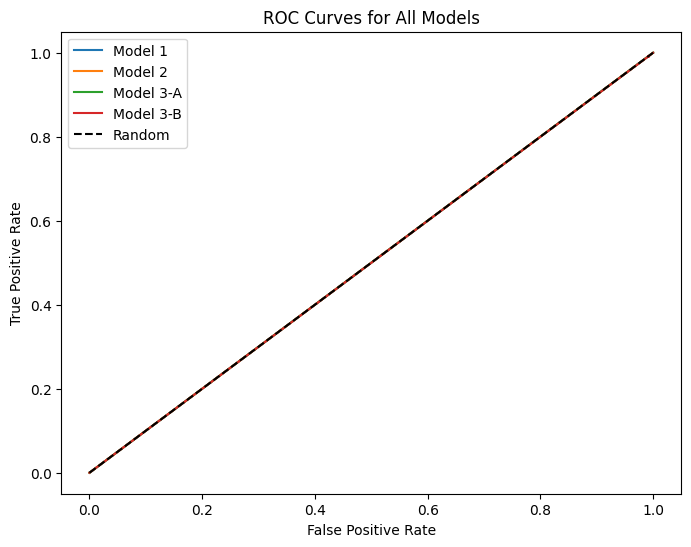

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Model 1
if m1_fpr is not None:
    plt.plot(m1_fpr, m1_tpr, label='Model 1')
# Model 2  (use m2a_*)
if m2a_fpr is not None:
    plt.plot(m2a_fpr, m2a_tpr, label='Model 2')
# Model 3-A
if m3a_fpr is not None:
    plt.plot(m3a_fpr, m3a_tpr, label='Model 3-A')
# Model 3-B
if m3b_fpr is not None:
    plt.plot(m3b_fpr, m3b_tpr, label='Model 3-B')
# Random baseline
plt.plot([0,1], [0,1], 'k--', label='Random')

plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ROC curve plot shows that every model’s ROC curve lying exactly on the random classifier, emphasizing that the models can’t rank “up” days above “down” or show no discriminative power.

## All Models performance observations:

Models 1, 2 are now numerically stable after cleaning and training and all converge to the same trivial solution, predicting the majority class (“up”) for every sample. Despite different architectures, their accuracy (~0.520) and ROC-AUC ≈ 0.50 show no discriminative ability.

Models 3-A and 3-B are numerically stable but collapse to a trivial strategy that predicts the majority class (“up”) for every sample. Their accuracy (~0.516) reflects class imbalance, and ROC-AUC ≈ 0.50 confirms no ranking ability. The deeper embedding and denser layers in 3-B offer no improvement.

**Takeaway:**

Increasing model depth, adding dense heads, or introducing symbol embeddings does not overcome the lack of predictive signal in short-horizon price data. Meaningful improvement will require richer feature sets (technical indicators, order-book information, sentiment, macroeconomic factors) and longer historical context, rather than additional architectural complexity.